# Geodesic Plots

In [1]:
#Modules
import jax.numpy as jnp
import jax.random as jrandom
from jax import vmap

from abc import ABC

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from geodesics import GradientDescent, JAXOptimization, ScipyOptimization, GC_LineSearch
from geodesics import GradientDescent_for, JAXOptimization_for, GC_LineSearch_for
from manifolds import nSphere, nEuclidean, nParaboloid, HyperbolicParaboloid

2024-06-01 00:48:50.957931: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
plt.rcParams.update({'font.size': 20})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

## Hyper-Parameters

In [3]:
tol = 1e-4
max_iter = 1000
T = 100
line_search_iter = 100

### Gradient Descent

In [4]:
grad_decay = 0.90
grad_lr_rate = 1.0

### JAX Optimization

In [5]:
jax_lr_rate = 0.01

### Geodesic Control

In [6]:
gc_decay = 0.9
gc_lr_rate = 1.0

## Geodesic Computations on $\mathbb{S}^{2}$

### Plotting

In [6]:
M = nSphere(dim=2)

In [7]:
#x0 = jnp.array([jnp.cos(5*jnp.pi/4),jnp.sin(5*jnp.pi/4),0.8])
#xT = jnp.array([jnp.cos(0.0),jnp.sin(0.0),0.8])

#x0 /= jnp.linalg.norm(x0)
#xT /= jnp.linalg.norm(xT)

#z0 = M.invF(x0)
#zT = M.invF(xT)

In [8]:
s2_z0 = -jnp.linspace(0,1,2)
s2_zT = jnp.ones(2, dtype=jnp.float32)

s2_x0 = M.F(s2_z0)
s2_xT = M.F(s2_zT)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [9]:
class SpherePlot(ABC):
    def __init__(self, seed=2712):
        
        self.seed = 2712
        self.rng_key = jrandom.PRNGKey(seed)

    def sphere_grid(self, n_points:int=100):
        self.rng_key, subkey = jrandom.split(self.rng_key)
        
        theta = jnp.linspace(0.0, jnp.pi*1, n_points)
        phi   = jnp.linspace(0.0, jnp.pi*2, n_points)

        # Creating the coordinate grid for the unit sphere.
        x1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
        x2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
        x3 = jnp.outer(jnp.cos(theta), jnp.ones(n_points))
        
        return x1,x2,x3
         

In [10]:
plot_sphere = SpherePlot()

### Ground Truth

In [11]:
s2_xt_true = M.Geodesic(s2_z0,s2_zT)
s2_true_dist = M.dist(s2_z0,s2_zT)

### Gradient Descent

In [12]:
Geodesic = GradientDescent(M = M,
                           init_fun=None,
                           lr_rate=grad_lr_rate,
                           decay_rate=grad_decay,
                           T=T,
                           max_iter=max_iter,
                           tol=tol,
                           line_search_iter=line_search_iter
                          )

In [13]:
zt = Geodesic.init_fun(s2_z0,s2_zT,T)
s2_xt_init = jnp.vstack((s2_x0, vmap(lambda z: M.F(z))(zt), s2_xT))
s2_init_length = M.length(zt)

In [14]:
zt, grad, s2_grad_idx = Geodesic(s2_z0,s2_zT)

In [15]:
s2_xt_grad = vmap(lambda z: M.F(z))(zt)
s2_grad_length = M.length(zt)

### JAX Optimization

In [16]:
Geodesic = JAXOptimization(M = M,
                          init_fun=None,
                          lr_rate=jax_lr_rate,
                          optimizer=None,
                          T=T,
                          max_iter=max_iter,
                          tol=tol)

In [17]:
zt, grad, s2_jax_idx = Geodesic(s2_z0,s2_zT)

In [18]:
s2_xt_jax = vmap(lambda z: M.F(z))(zt)
s2_jax_length = M.length(zt)

### Scipy Optimization

In [19]:
Geodesic = ScipyOptimization(M = M,
                             T=T,
                             tol=tol,
                             max_iter=max_iter,
                             method="BFGS",
                            )

In [20]:
zt, grad, s2_scipy_idx = Geodesic(s2_z0,s2_zT)

In [21]:
s2_xt_scipy = vmap(lambda z: M.F(z))(zt)
s2_scipy_length = M.length(zt)

### Geodesic Control

In [22]:
Geodesic = GC_LineSearch(M=M,
                        init_fun=None,
                        lr_rate=gc_lr_rate,
                        T=T,
                        decay_rate=0.5,
                        tol=tol,
                        max_iter=max_iter,
                        line_search_iter=line_search_iter
                        )

In [23]:
zt, grad, s2_gc_idx = Geodesic(s2_z0,s2_zT)

In [24]:
s2_xt_gc = vmap(lambda z: M.F(z))(zt)
s2_gc_length = M.length(zt)

### Plotting

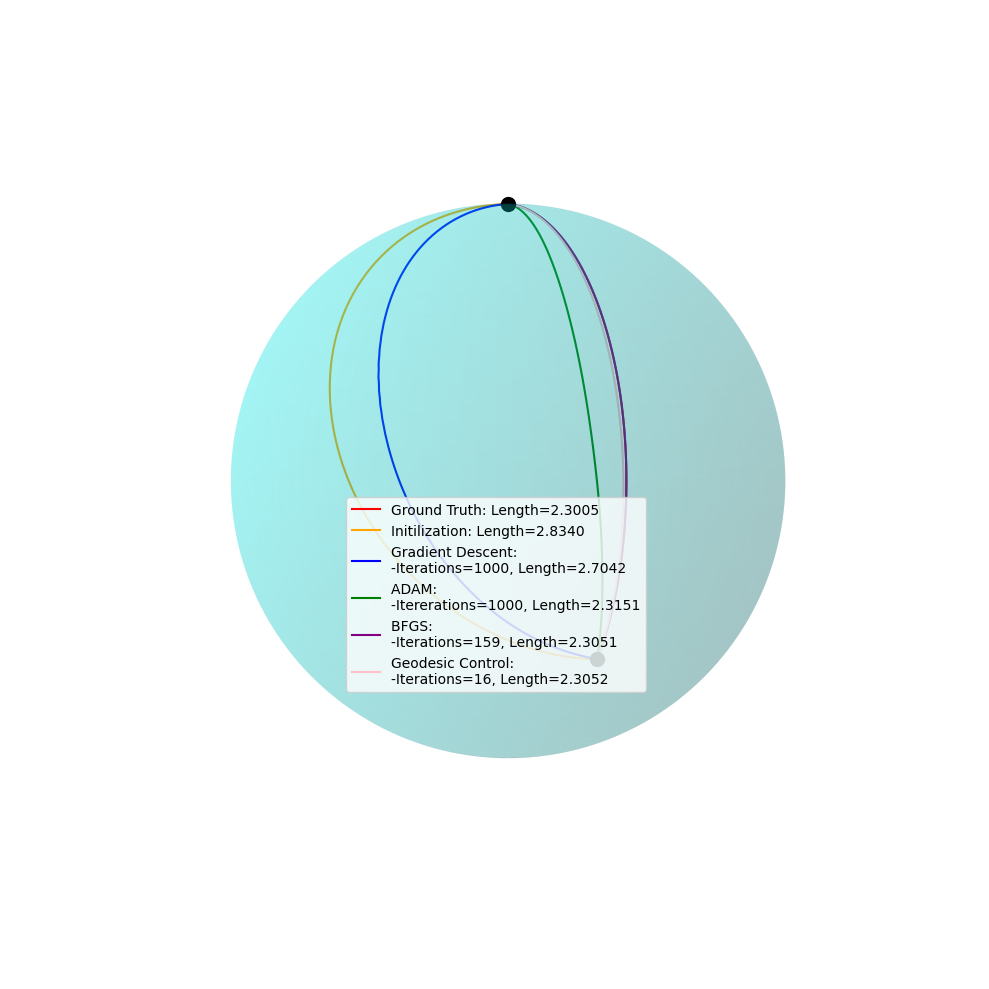

In [25]:
x1,x2,x3 = plot_sphere.sphere_grid(100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.scatter(s2_x0[0], s2_x0[1], s2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(s2_xT[0], s2_xT[1], s2_xT[2], color='black', alpha=1.0, s=100)
ax.plot(s2_xt_true[:,0], s2_xt_true[:,1], s2_xt_true[:,2], color='red', alpha=1.0,
       label=f"Ground Truth: Length={s2_true_dist:.4f}")
ax.plot(s2_xt_init[:,0], s2_xt_init[:,1], s2_xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={s2_init_length:.4f}")
ax.plot(s2_xt_grad[:,0], s2_xt_grad[:,1], s2_xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={s2_grad_idx}, Length={s2_grad_length:.4f}")
ax.plot(s2_xt_jax[:,0], s2_xt_jax[:,1], s2_xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Itererations={s2_jax_idx}, Length={s2_jax_length:.4f}")
ax.plot(s2_xt_scipy[:,0], s2_xt_scipy[:,1], s2_xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={s2_scipy_idx}, Length={s2_scipy_length:.4f}")
ax.plot(s2_xt_gc[:,0], s2_xt_gc[:,1], s2_xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={s2_gc_idx}, Length={s2_gc_length:.4f}")
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.35,0.3), ncol=1)

plt.show()


## Geodesic Computations on Paraboloid

### Plotting

In [26]:
M = nParaboloid(dim=2)

In [27]:
#r = 1.0
#p2_z0 = r*jnp.array([jnp.cos(-5*jnp.pi/4), jnp.sin(-5*jnp.pi/4)])
#p2_zT = r*jnp.array([jnp.cos(0.0),jnp.sin(0.0)])

#x0 = M.F(z0)
#xT = M.F(zT)

In [28]:
p_z0 = -jnp.linspace(0,1,2)
p_zT = jnp.ones(2)

p_x0 = M.F(p_z0)
p_xT = M.F(p_zT)

In [29]:
class ParaboloidPlot(ABC):
    def __init__(self):
        
        return

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2+X2**2
         

In [30]:
plot_paraboloid = ParaboloidPlot()

### Gradient Descent

In [31]:
Geodesic = GradientDescent(M = M,
                           init_fun=None,
                           lr_rate=grad_lr_rate,
                           decay_rate=grad_decay,
                           T=T,
                           max_iter=max_iter,
                           tol=tol,
                           line_search_iter=line_search_iter
                          )

In [32]:
zt = Geodesic.init_fun(p_z0,p_zT,T)
p_xt_init = jnp.vstack((p_x0, vmap(lambda z: M.F(z))(zt), p_xT))
p_init_length = M.length(p_xt_init)

In [33]:
zt, grad, p_grad_idx = Geodesic(p_z0,p_zT)

In [34]:
p_xt_grad = vmap(lambda z: M.F(z))(zt)
p_grad_length = M.length(zt)

### JAX Optimization

In [35]:
Geodesic = JAXOptimization(M = M,
                          init_fun=None,
                          lr_rate=jax_lr_rate,
                          optimizer=None,
                          T=T,
                          max_iter=max_iter,
                          tol=tol)

In [36]:
zt, grad, p_jax_idx = Geodesic(p_z0,p_zT)

In [37]:
p_xt_jax = vmap(lambda z: M.F(z))(zt)
p_jax_length = M.length(zt)

### Scipy Optimization

In [38]:
Geodesic = ScipyOptimization(M = M,
                             T=T,
                             tol=tol,
                             max_iter=max_iter,
                             method="BFGS",
                            )

In [39]:
zt, grad, p_scipy_idx = Geodesic(p_z0,p_zT)

In [40]:
p_xt_scipy = vmap(lambda z: M.F(z))(zt)
p_scipy_length = M.length(zt)

### Geodesic Control

In [41]:
Geodesic = GC_LineSearch(M=M,
                        init_fun=None,
                        lr_rate=gc_lr_rate,
                        T=T,
                        decay_rate=0.5,
                        tol=tol,
                        max_iter=max_iter,
                        line_search_iter=line_search_iter
                        )

In [42]:
zt, grad, p_gc_idx = Geodesic(p_z0,p_zT)

In [43]:
p_xt_gc = vmap(lambda z: M.F(z))(zt)
p_gc_length = M.length(zt)

### Plotting

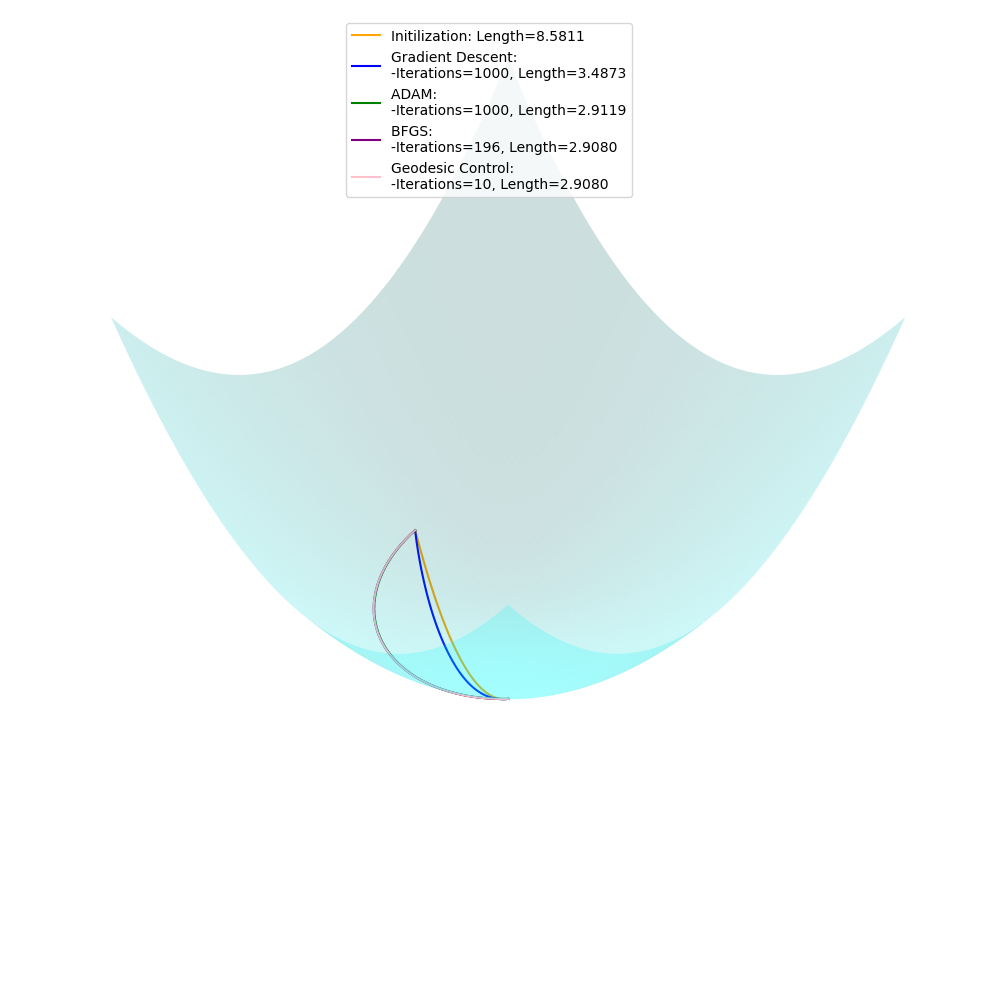

In [45]:
x1,x2,x3 = ParaboloidPlot.grid(100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.plot(p_xt_init[:,0], p_xt_init[:,1], p_xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={p_init_length:.4f}")
ax.plot(p_xt_grad[:,0], p_xt_grad[:,1], p_xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={p_grad_idx}, Length={p_grad_length:.4f}")
ax.plot(p_xt_jax[:,0], p_xt_jax[:,1], p_xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Iterations={p_jax_idx}, Length={p_jax_length:.4f}")
ax.plot(p_xt_scipy[:,0], p_xt_scipy[:,1], p_xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={p_scipy_idx}, Length={p_scipy_length:.4f}")
ax.plot(p_xt_gc[:,0], p_xt_gc[:,1], p_xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={p_gc_idx}, Length={p_gc_length:.4f}")
ax.set_axis_off()
ax.view_init(elev=45., azim=45.)
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.35,0.8), ncol=1)

plt.show()


## Geodesic Computations on Hyperbolic Paraboloid

### Plotting

In [46]:
M = HyperbolicParaboloid()

In [47]:
r = 1.0
hp_z0 = r*jnp.array([-3.,-3.])
hp_zT = r*jnp.array([3.,-3.])

hp_x0 = M.F(hp_z0)
hp_xT = M.F(hp_zT)

In [48]:
class HyperbolicParaboloidPlot(ABC):
    def __init__(self):
        
        return

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-5.0, 5.0, n_points)
        x2 = jnp.linspace(-5.0, 5.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2-X2**2
         

In [49]:
plot_hyperbolicparaboloid = HyperbolicParaboloidPlot()

### Gradient Descent

In [50]:
Geodesic = GradientDescent(M = M,
                           init_fun=None,
                           lr_rate=grad_lr_rate,
                           decay_rate=grad_decay,
                           T=T,
                           max_iter=max_iter,
                           tol=tol,
                           line_search_iter=line_search_iter
                          )

In [51]:
zt = Geodesic.init_fun(hp_z0,hp_zT,T)
hp_xt_init = jnp.vstack((hp_x0, vmap(lambda z: M.F(z))(zt), hp_xT))
hp_init_length = M.length(zt)

In [52]:
zt, grad, hp_grad_idx = Geodesic(hp_z0,hp_zT)

In [53]:
hp_xt_grad = vmap(lambda z: M.F(z))(zt)
hp_grad_length = M.length(zt)

### JAX Optimization

In [54]:
Geodesic = JAXOptimization(M = M,
                          init_fun=None,
                          lr_rate=jax_lr_rate,
                          optimizer=None,
                          T=T,
                          max_iter=max_iter,
                          tol=tol)

In [55]:
zt, grad, hp_jax_idx = Geodesic(hp_z0,hp_zT)

In [56]:
hp_xt_jax = vmap(lambda z: M.F(z))(zt)
hp_jax_length = M.length(zt)

### Scipy Optimization

In [57]:
Geodesic = ScipyOptimization(M = M,
                             T=T,
                             tol=tol,
                             max_iter=max_iter,
                             method="BFGS",
                            )

In [58]:
zt, grad, hp_scipy_idx = Geodesic(hp_z0,hp_zT)

In [59]:
hp_xt_scipy = vmap(lambda z: M.F(z))(zt)
hp_scipy_length = M.length(zt)

### Geodesic Control

In [60]:
Geodesic = GC_LineSearch(M=M,
                        init_fun=None,
                        lr_rate=gc_lr_rate,
                        T=T,
                        decay_rate=0.9,
                        tol=tol,
                        max_iter=max_iter,
                        line_search_iter=line_search_iter
                        )

In [61]:
zt, grad, hp_gc_idx = Geodesic(hp_z0,hp_zT)

In [62]:
hp_xt_gc = vmap(lambda z: M.F(z))(zt)
hp_gc_length = M.length(hp_xt_gc)

### Plotting

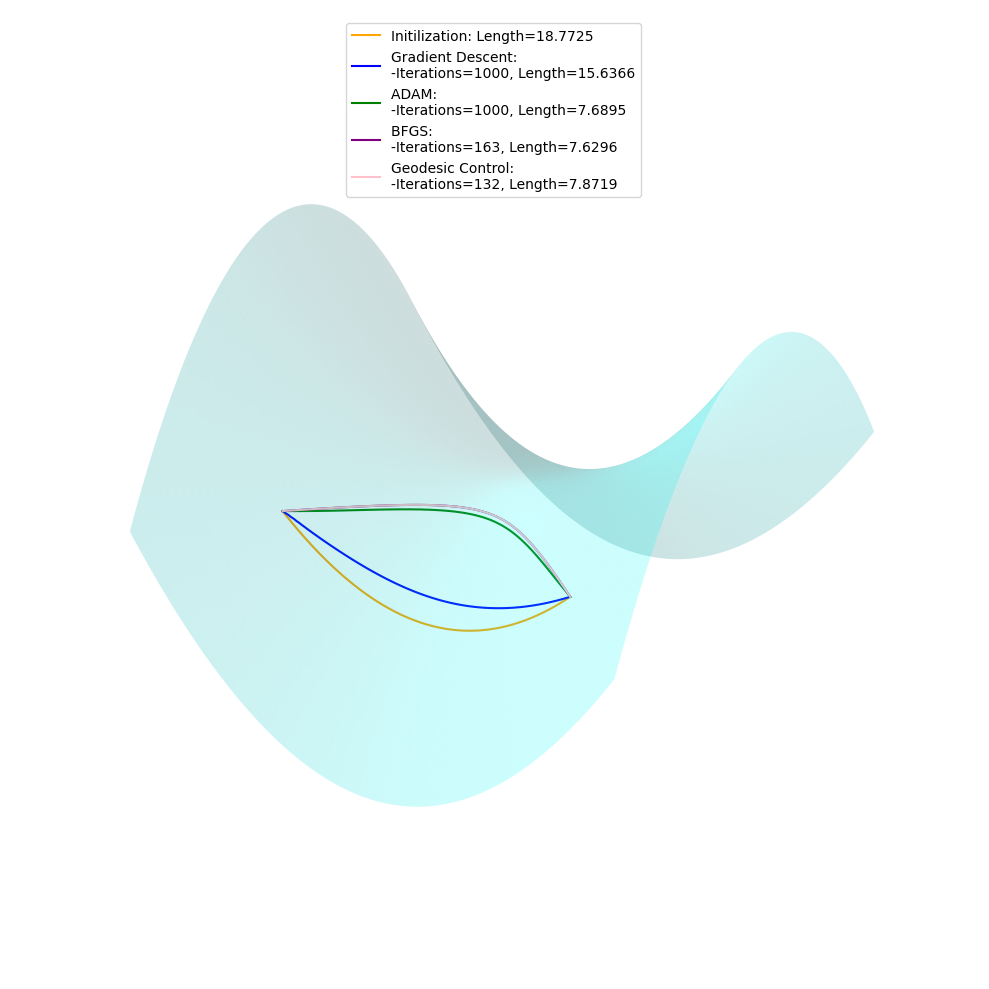

In [64]:
x1,x2,x3 = HyperbolicParaboloidPlot.grid(100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.plot(hp_xt_init[:,0], hp_xt_init[:,1], hp_xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={hp_init_length:.4f}")
ax.plot(hp_xt_grad[:,0], hp_xt_grad[:,1], hp_xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={hp_grad_idx}, Length={hp_grad_length:.4f}")
ax.plot(hp_xt_jax[:,0], hp_xt_jax[:,1], hp_xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Iterations={hp_jax_idx}, Length={hp_jax_length:.4f}")
ax.plot(hp_xt_scipy[:,0], hp_xt_scipy[:,1], hp_xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={hp_scipy_idx}, Length={hp_scipy_length:.4f}")
ax.plot(hp_xt_gc[:,0], hp_xt_gc[:,1], hp_xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={hp_gc_idx}, Length={hp_gc_length:.4f}")
ax.set_axis_off()
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.35,0.8), ncol=1)

plt.show()


## Plotting

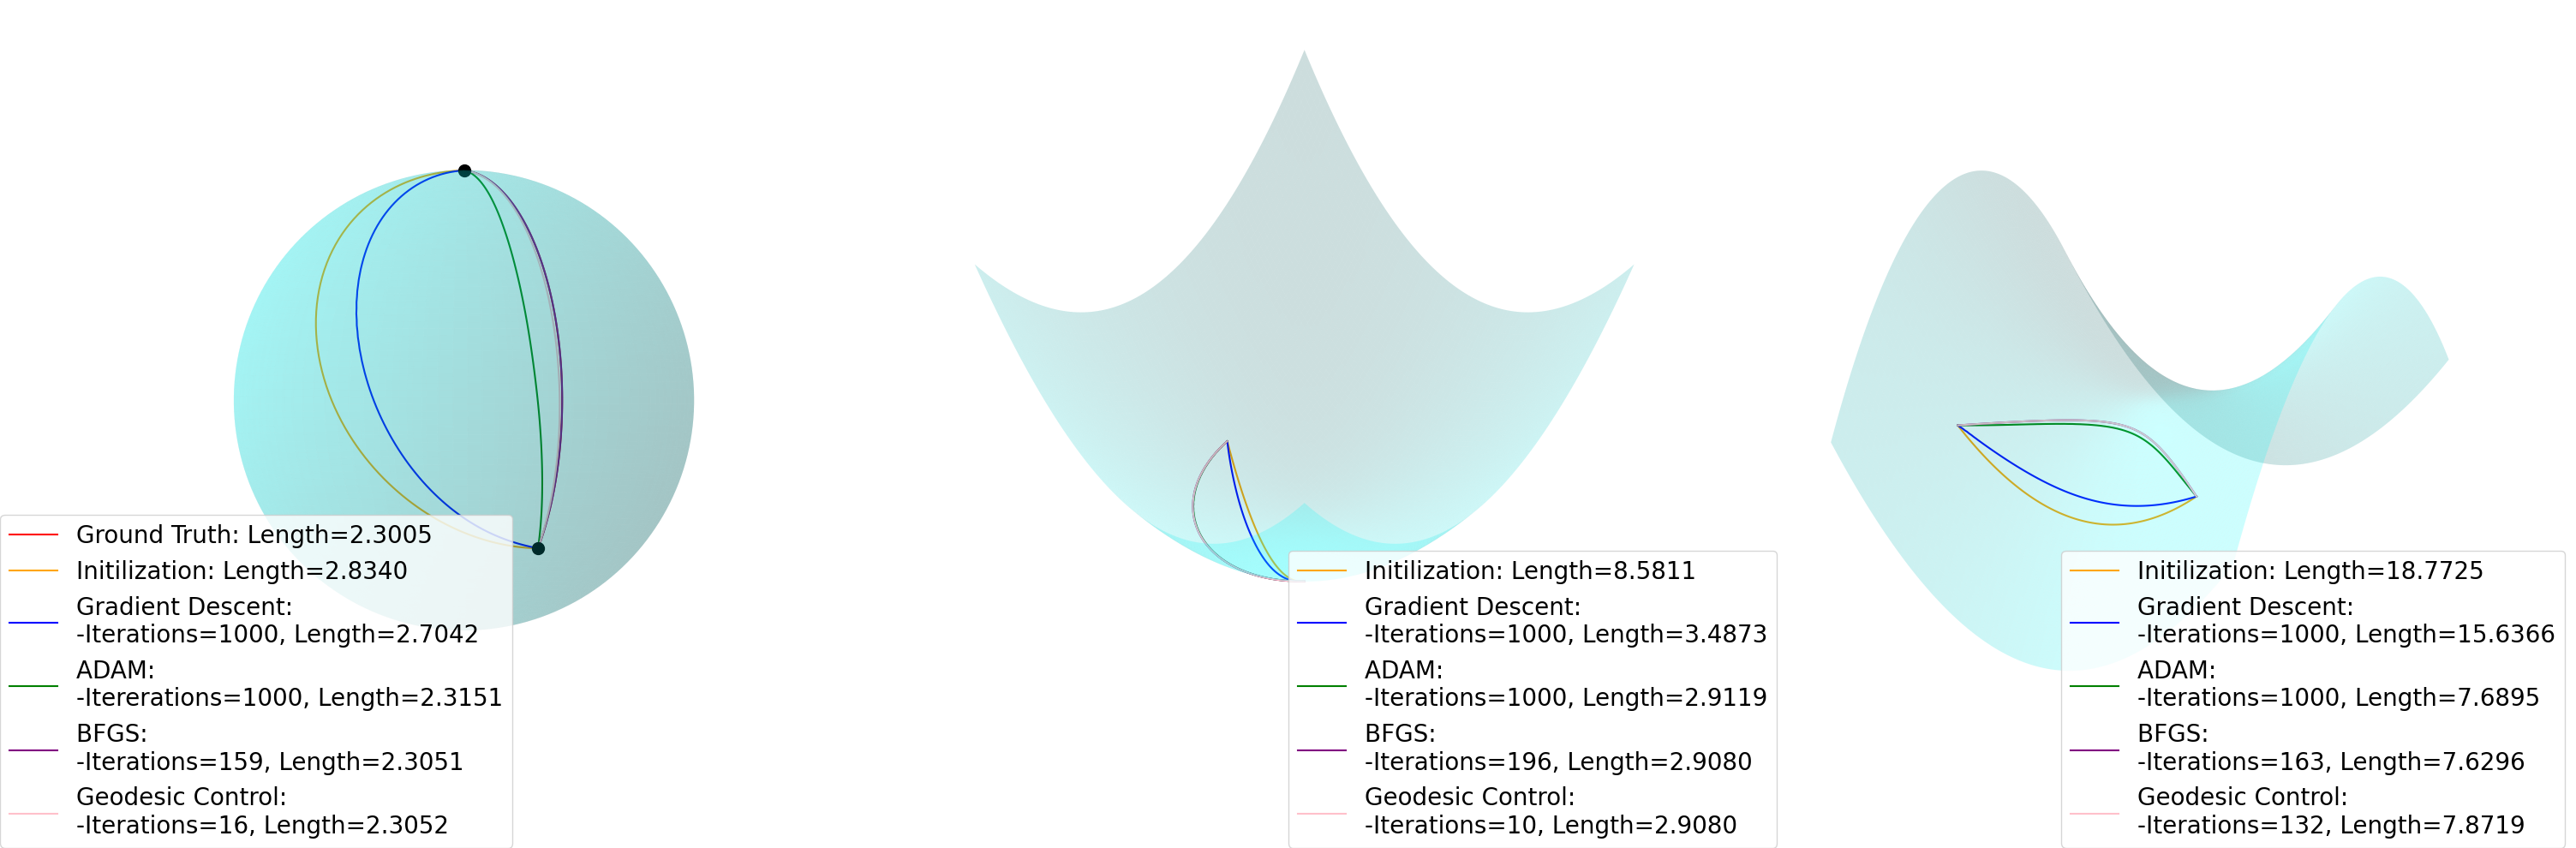

In [73]:
fig = plt.figure(figsize=(30,10))

x1,x2,x3 = plot_sphere.sphere_grid(100)
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.scatter(s2_x0[0], s2_x0[1], s2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(s2_xT[0], s2_xT[1], s2_xT[2], color='black', alpha=1.0, s=100)
ax.plot(s2_xt_true[:,0], s2_xt_true[:,1], s2_xt_true[:,2], color='red', alpha=1.0,
       label=f"Ground Truth: Length={s2_true_dist:.4f}")
ax.plot(s2_xt_init[:,0], s2_xt_init[:,1], s2_xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={s2_init_length:.4f}")
ax.plot(s2_xt_grad[:,0], s2_xt_grad[:,1], s2_xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={s2_grad_idx}, Length={s2_grad_length:.4f}")
ax.plot(s2_xt_jax[:,0], s2_xt_jax[:,1], s2_xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Itererations={s2_jax_idx}, Length={s2_jax_length:.4f}")
ax.plot(s2_xt_scipy[:,0], s2_xt_scipy[:,1], s2_xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={s2_scipy_idx}, Length={s2_scipy_length:.4f}")
ax.plot(s2_xt_gc[:,0], s2_xt_gc[:,1], s2_xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={s2_gc_idx}, Length={s2_gc_length:.4f}")
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.0,0.0), ncol=1)

x1,x2,x3 = ParaboloidPlot.grid(100)
ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.plot(p_xt_init[:,0], p_xt_init[:,1], p_xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={p_init_length:.4f}")
ax.plot(p_xt_grad[:,0], p_xt_grad[:,1], p_xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={p_grad_idx}, Length={p_grad_length:.4f}")
ax.plot(p_xt_jax[:,0], p_xt_jax[:,1], p_xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Iterations={p_jax_idx}, Length={p_jax_length:.4f}")
ax.plot(p_xt_scipy[:,0], p_xt_scipy[:,1], p_xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={p_scipy_idx}, Length={p_scipy_length:.4f}")
ax.plot(p_xt_gc[:,0], p_xt_gc[:,1], p_xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={p_gc_idx}, Length={p_gc_length:.4f}")
ax.set_axis_off()
ax.view_init(elev=45., azim=45.)
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.5,0.0), ncol=1)

x1,x2,x3 = HyperbolicParaboloidPlot.grid(100)
ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.plot(hp_xt_init[:,0], hp_xt_init[:,1], hp_xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={hp_init_length:.4f}")
ax.plot(hp_xt_grad[:,0], hp_xt_grad[:,1], hp_xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={hp_grad_idx}, Length={hp_grad_length:.4f}")
ax.plot(hp_xt_jax[:,0], hp_xt_jax[:,1], hp_xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Iterations={hp_jax_idx}, Length={hp_jax_length:.4f}")
ax.plot(hp_xt_scipy[:,0], hp_xt_scipy[:,1], hp_xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={hp_scipy_idx}, Length={hp_scipy_length:.4f}")
ax.plot(hp_xt_gc[:,0], hp_xt_gc[:,1], hp_xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={hp_gc_idx}, Length={hp_gc_length:.4f}")
ax.set_axis_off()
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.8,0.0), ncol=1)

plt.show()



## Geodesic Computations on $\mathbb{S}^{2}$

### Plotting

In [7]:
M = nSphere(dim=2)

In [8]:
#x0 = jnp.array([jnp.cos(5*jnp.pi/4),jnp.sin(5*jnp.pi/4),0.8])
#xT = jnp.array([jnp.cos(0.0),jnp.sin(0.0),0.8])

#x0 /= jnp.linalg.norm(x0)
#xT /= jnp.linalg.norm(xT)

#z0 = M.invF(x0)
#zT = M.invF(xT)

In [9]:
s2_z0 = -jnp.linspace(0,1,2)
s2_zT = jnp.ones(2, dtype=jnp.float32)

s2_x0 = M.F(s2_z0)
s2_xT = M.F(s2_zT)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [10]:
class SpherePlot(ABC):
    def __init__(self, seed=2712):
        
        self.seed = 2712
        self.rng_key = jrandom.PRNGKey(seed)

    def sphere_grid(self, n_points:int=100):
        self.rng_key, subkey = jrandom.split(self.rng_key)
        
        theta = jnp.linspace(0.0, jnp.pi*1, n_points)
        phi   = jnp.linspace(0.0, jnp.pi*2, n_points)

        # Creating the coordinate grid for the unit sphere.
        x1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
        x2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
        x3 = jnp.outer(jnp.cos(theta), jnp.ones(n_points))
        
        return x1,x2,x3
         

In [11]:
plot_sphere = SpherePlot()

### Ground Truth

In [12]:
s2_xt_true = M.Geodesic(s2_z0,s2_zT)
s2_true_dist = M.dist(s2_z0,s2_zT)

### Gradient Descent

In [13]:
Geodesic = GradientDescent_for(M = M,
                           init_fun=None,
                           lr_rate=grad_lr_rate,
                           decay_rate=grad_decay,
                           T=T,
                           max_iter=max_iter,
                           line_search_iter=line_search_iter
                          )

In [14]:
zt = Geodesic.init_fun(s2_z0,s2_zT,T)

In [15]:
zt = Geodesic(s2_z0,s2_zT)

In [15]:
s2_grad_error = 

### JAX Optimization

In [16]:
Geodesic = JAXOptimization(M = M,
                          init_fun=None,
                          lr_rate=jax_lr_rate,
                          optimizer=None,
                          T=T,
                          max_iter=max_iter,
                          tol=tol)

In [17]:
zt, grad, s2_jax_idx = Geodesic(s2_z0,s2_zT)

In [18]:
s2_xt_jax = vmap(lambda z: M.F(z))(zt)
s2_jax_length = M.length(zt)

### Scipy Optimization

In [19]:
Geodesic = ScipyOptimization(M = M,
                             T=T,
                             tol=tol,
                             max_iter=max_iter,
                             method="BFGS",
                            )

In [20]:
zt, grad, s2_scipy_idx = Geodesic(s2_z0,s2_zT)

In [21]:
s2_xt_scipy = vmap(lambda z: M.F(z))(zt)
s2_scipy_length = M.length(zt)

### Geodesic Control

In [22]:
Geodesic = GC_LineSearch(M=M,
                        init_fun=None,
                        lr_rate=gc_lr_rate,
                        T=T,
                        decay_rate=0.5,
                        tol=tol,
                        max_iter=max_iter,
                        line_search_iter=line_search_iter
                        )

In [23]:
zt, grad, s2_gc_idx = Geodesic(s2_z0,s2_zT)

In [24]:
s2_xt_gc = vmap(lambda z: M.F(z))(zt)
s2_gc_length = M.length(zt)

### Plotting

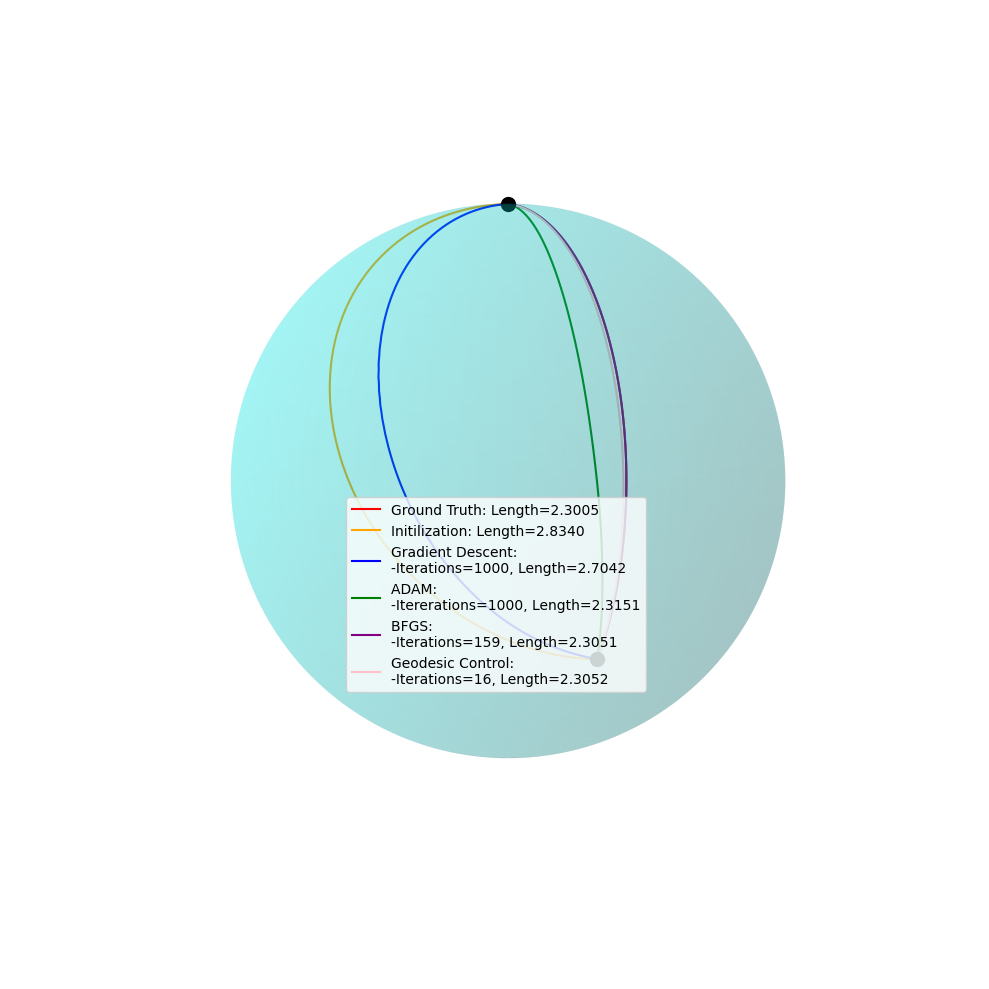

In [25]:
x1,x2,x3 = plot_sphere.sphere_grid(100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.scatter(s2_x0[0], s2_x0[1], s2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(s2_xT[0], s2_xT[1], s2_xT[2], color='black', alpha=1.0, s=100)
ax.plot(s2_xt_true[:,0], s2_xt_true[:,1], s2_xt_true[:,2], color='red', alpha=1.0,
       label=f"Ground Truth: Length={s2_true_dist:.4f}")
ax.plot(s2_xt_init[:,0], s2_xt_init[:,1], s2_xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={s2_init_length:.4f}")
ax.plot(s2_xt_grad[:,0], s2_xt_grad[:,1], s2_xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={s2_grad_idx}, Length={s2_grad_length:.4f}")
ax.plot(s2_xt_jax[:,0], s2_xt_jax[:,1], s2_xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Itererations={s2_jax_idx}, Length={s2_jax_length:.4f}")
ax.plot(s2_xt_scipy[:,0], s2_xt_scipy[:,1], s2_xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={s2_scipy_idx}, Length={s2_scipy_length:.4f}")
ax.plot(s2_xt_gc[:,0], s2_xt_gc[:,1], s2_xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={s2_gc_idx}, Length={s2_gc_length:.4f}")
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.35,0.3), ncol=1)

plt.show()


## Geodesic Computations on Paraboloid

### Plotting

In [26]:
M = nParaboloid(dim=2)

In [27]:
#r = 1.0
#p2_z0 = r*jnp.array([jnp.cos(-5*jnp.pi/4), jnp.sin(-5*jnp.pi/4)])
#p2_zT = r*jnp.array([jnp.cos(0.0),jnp.sin(0.0)])

#x0 = M.F(z0)
#xT = M.F(zT)

In [28]:
p_z0 = -jnp.linspace(0,1,2)
p_zT = jnp.ones(2)

p_x0 = M.F(p_z0)
p_xT = M.F(p_zT)

In [29]:
class ParaboloidPlot(ABC):
    def __init__(self):
        
        return

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2+X2**2
         

In [30]:
plot_paraboloid = ParaboloidPlot()

### Gradient Descent

In [31]:
Geodesic = GradientDescent(M = M,
                           init_fun=None,
                           lr_rate=grad_lr_rate,
                           decay_rate=grad_decay,
                           T=T,
                           max_iter=max_iter,
                           tol=tol,
                           line_search_iter=line_search_iter
                          )

In [32]:
zt = Geodesic.init_fun(p_z0,p_zT,T)
p_xt_init = jnp.vstack((p_x0, vmap(lambda z: M.F(z))(zt), p_xT))
p_init_length = M.length(p_xt_init)

In [33]:
zt, grad, p_grad_idx = Geodesic(p_z0,p_zT)

In [34]:
p_xt_grad = vmap(lambda z: M.F(z))(zt)
p_grad_length = M.length(zt)

### JAX Optimization

In [35]:
Geodesic = JAXOptimization(M = M,
                          init_fun=None,
                          lr_rate=jax_lr_rate,
                          optimizer=None,
                          T=T,
                          max_iter=max_iter,
                          tol=tol)

In [36]:
zt, grad, p_jax_idx = Geodesic(p_z0,p_zT)

In [37]:
p_xt_jax = vmap(lambda z: M.F(z))(zt)
p_jax_length = M.length(zt)

### Scipy Optimization

In [38]:
Geodesic = ScipyOptimization(M = M,
                             T=T,
                             tol=tol,
                             max_iter=max_iter,
                             method="BFGS",
                            )

In [39]:
zt, grad, p_scipy_idx = Geodesic(p_z0,p_zT)

In [40]:
p_xt_scipy = vmap(lambda z: M.F(z))(zt)
p_scipy_length = M.length(zt)

### Geodesic Control

In [41]:
Geodesic = GC_LineSearch(M=M,
                        init_fun=None,
                        lr_rate=gc_lr_rate,
                        T=T,
                        decay_rate=0.5,
                        tol=tol,
                        max_iter=max_iter,
                        line_search_iter=line_search_iter
                        )

In [42]:
zt, grad, p_gc_idx = Geodesic(p_z0,p_zT)

In [43]:
p_xt_gc = vmap(lambda z: M.F(z))(zt)
p_gc_length = M.length(zt)

### Plotting

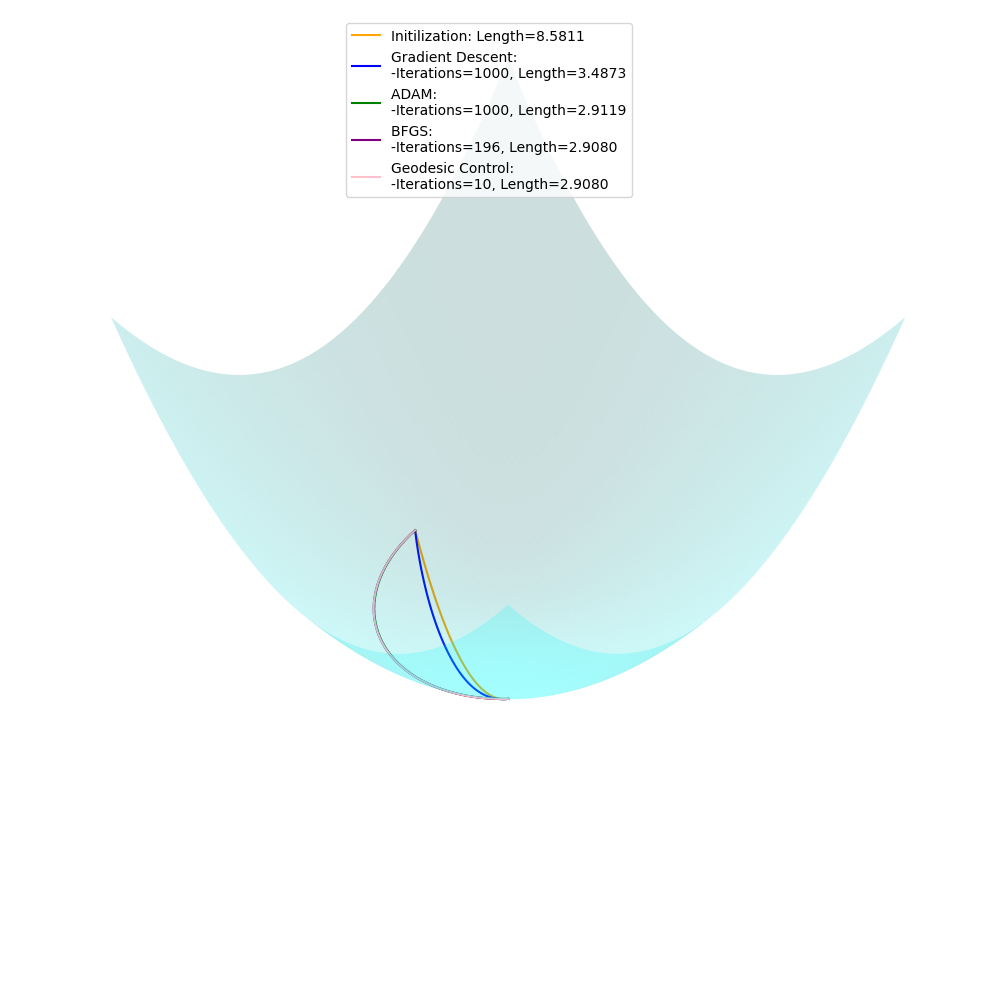

In [45]:
x1,x2,x3 = ParaboloidPlot.grid(100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.plot(p_xt_init[:,0], p_xt_init[:,1], p_xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={p_init_length:.4f}")
ax.plot(p_xt_grad[:,0], p_xt_grad[:,1], p_xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={p_grad_idx}, Length={p_grad_length:.4f}")
ax.plot(p_xt_jax[:,0], p_xt_jax[:,1], p_xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Iterations={p_jax_idx}, Length={p_jax_length:.4f}")
ax.plot(p_xt_scipy[:,0], p_xt_scipy[:,1], p_xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={p_scipy_idx}, Length={p_scipy_length:.4f}")
ax.plot(p_xt_gc[:,0], p_xt_gc[:,1], p_xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={p_gc_idx}, Length={p_gc_length:.4f}")
ax.set_axis_off()
ax.view_init(elev=45., azim=45.)
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.35,0.8), ncol=1)

plt.show()


## Geodesic Computations on Hyperbolic Paraboloid

### Plotting

In [46]:
M = HyperbolicParaboloid()

In [47]:
r = 1.0
hp_z0 = r*jnp.array([-3.,-3.])
hp_zT = r*jnp.array([3.,-3.])

hp_x0 = M.F(hp_z0)
hp_xT = M.F(hp_zT)

In [48]:
class HyperbolicParaboloidPlot(ABC):
    def __init__(self):
        
        return

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-5.0, 5.0, n_points)
        x2 = jnp.linspace(-5.0, 5.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2-X2**2
         

In [49]:
plot_hyperbolicparaboloid = HyperbolicParaboloidPlot()

### Gradient Descent

In [50]:
Geodesic = GradientDescent(M = M,
                           init_fun=None,
                           lr_rate=grad_lr_rate,
                           decay_rate=grad_decay,
                           T=T,
                           max_iter=max_iter,
                           tol=tol,
                           line_search_iter=line_search_iter
                          )

In [51]:
zt = Geodesic.init_fun(hp_z0,hp_zT,T)
hp_xt_init = jnp.vstack((hp_x0, vmap(lambda z: M.F(z))(zt), hp_xT))
hp_init_length = M.length(zt)

In [52]:
zt, grad, hp_grad_idx = Geodesic(hp_z0,hp_zT)

In [53]:
hp_xt_grad = vmap(lambda z: M.F(z))(zt)
hp_grad_length = M.length(zt)

### JAX Optimization

In [54]:
Geodesic = JAXOptimization(M = M,
                          init_fun=None,
                          lr_rate=jax_lr_rate,
                          optimizer=None,
                          T=T,
                          max_iter=max_iter,
                          tol=tol)

In [55]:
zt, grad, hp_jax_idx = Geodesic(hp_z0,hp_zT)

In [56]:
hp_xt_jax = vmap(lambda z: M.F(z))(zt)
hp_jax_length = M.length(zt)

### Scipy Optimization

In [57]:
Geodesic = ScipyOptimization(M = M,
                             T=T,
                             tol=tol,
                             max_iter=max_iter,
                             method="BFGS",
                            )

In [58]:
zt, grad, hp_scipy_idx = Geodesic(hp_z0,hp_zT)

In [59]:
hp_xt_scipy = vmap(lambda z: M.F(z))(zt)
hp_scipy_length = M.length(zt)

### Geodesic Control

In [60]:
Geodesic = GC_LineSearch(M=M,
                        init_fun=None,
                        lr_rate=gc_lr_rate,
                        T=T,
                        decay_rate=0.9,
                        tol=tol,
                        max_iter=max_iter,
                        line_search_iter=line_search_iter
                        )

In [61]:
zt, grad, hp_gc_idx = Geodesic(hp_z0,hp_zT)

In [62]:
hp_xt_gc = vmap(lambda z: M.F(z))(zt)
hp_gc_length = M.length(hp_xt_gc)

### Plotting

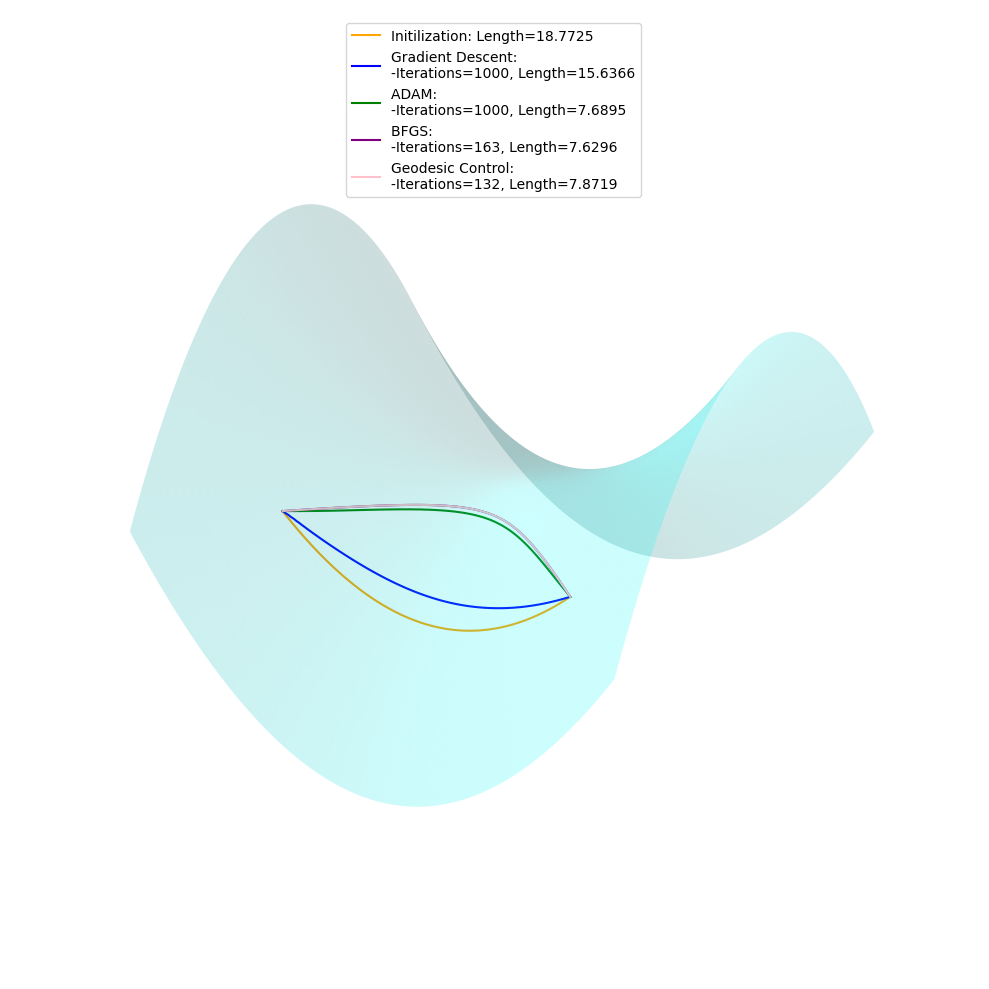

In [64]:
x1,x2,x3 = HyperbolicParaboloidPlot.grid(100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.plot(hp_xt_init[:,0], hp_xt_init[:,1], hp_xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={hp_init_length:.4f}")
ax.plot(hp_xt_grad[:,0], hp_xt_grad[:,1], hp_xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={hp_grad_idx}, Length={hp_grad_length:.4f}")
ax.plot(hp_xt_jax[:,0], hp_xt_jax[:,1], hp_xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Iterations={hp_jax_idx}, Length={hp_jax_length:.4f}")
ax.plot(hp_xt_scipy[:,0], hp_xt_scipy[:,1], hp_xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={hp_scipy_idx}, Length={hp_scipy_length:.4f}")
ax.plot(hp_xt_gc[:,0], hp_xt_gc[:,1], hp_xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={hp_gc_idx}, Length={hp_gc_length:.4f}")
ax.set_axis_off()
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.35,0.8), ncol=1)

plt.show()


## Plotting

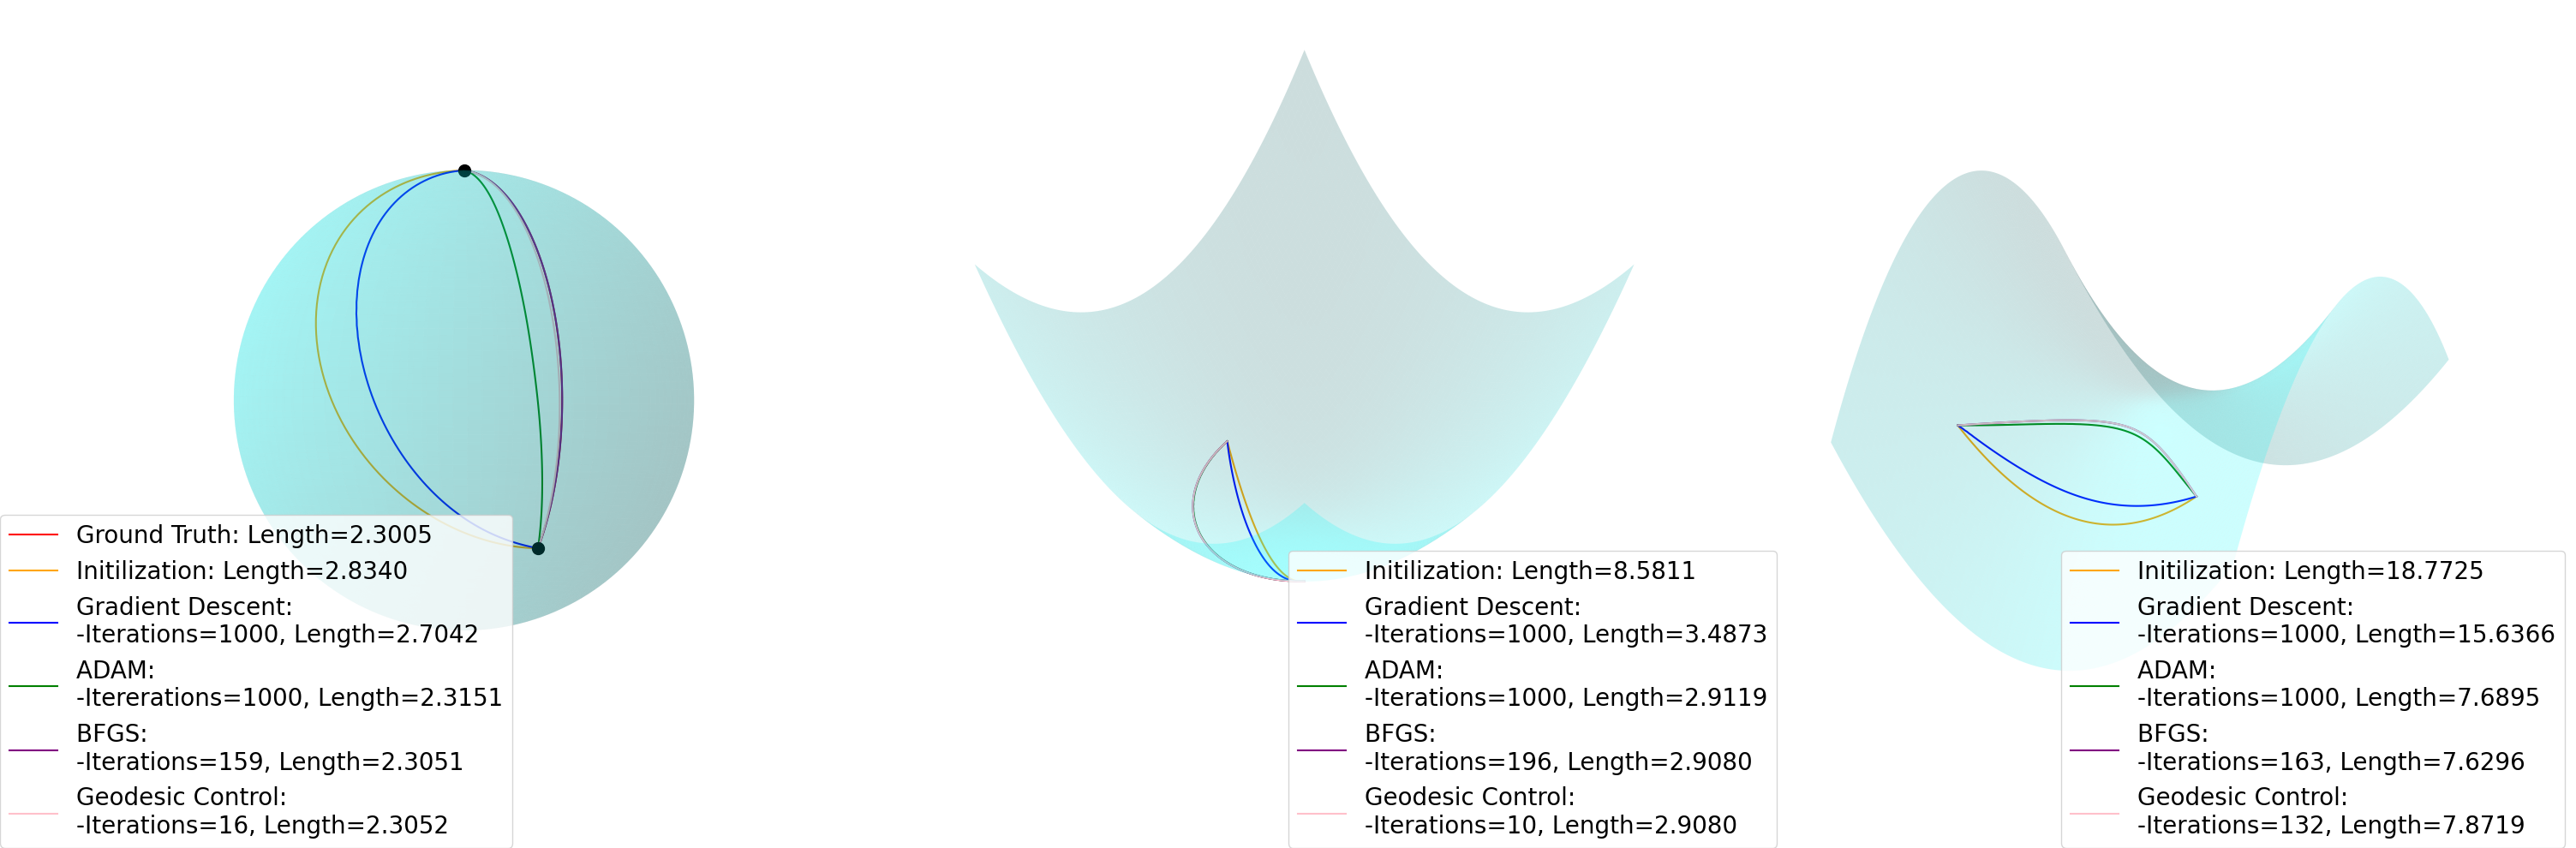

In [73]:
fig = plt.figure(figsize=(30,10))

x1,x2,x3 = plot_sphere.sphere_grid(100)
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.scatter(s2_x0[0], s2_x0[1], s2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(s2_xT[0], s2_xT[1], s2_xT[2], color='black', alpha=1.0, s=100)
ax.plot(s2_xt_true[:,0], s2_xt_true[:,1], s2_xt_true[:,2], color='red', alpha=1.0,
       label=f"Ground Truth: Length={s2_true_dist:.4f}")
ax.plot(s2_xt_init[:,0], s2_xt_init[:,1], s2_xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={s2_init_length:.4f}")
ax.plot(s2_xt_grad[:,0], s2_xt_grad[:,1], s2_xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={s2_grad_idx}, Length={s2_grad_length:.4f}")
ax.plot(s2_xt_jax[:,0], s2_xt_jax[:,1], s2_xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Itererations={s2_jax_idx}, Length={s2_jax_length:.4f}")
ax.plot(s2_xt_scipy[:,0], s2_xt_scipy[:,1], s2_xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={s2_scipy_idx}, Length={s2_scipy_length:.4f}")
ax.plot(s2_xt_gc[:,0], s2_xt_gc[:,1], s2_xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={s2_gc_idx}, Length={s2_gc_length:.4f}")
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.0,0.0), ncol=1)

x1,x2,x3 = ParaboloidPlot.grid(100)
ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.plot(p_xt_init[:,0], p_xt_init[:,1], p_xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={p_init_length:.4f}")
ax.plot(p_xt_grad[:,0], p_xt_grad[:,1], p_xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={p_grad_idx}, Length={p_grad_length:.4f}")
ax.plot(p_xt_jax[:,0], p_xt_jax[:,1], p_xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Iterations={p_jax_idx}, Length={p_jax_length:.4f}")
ax.plot(p_xt_scipy[:,0], p_xt_scipy[:,1], p_xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={p_scipy_idx}, Length={p_scipy_length:.4f}")
ax.plot(p_xt_gc[:,0], p_xt_gc[:,1], p_xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={p_gc_idx}, Length={p_gc_length:.4f}")
ax.set_axis_off()
ax.view_init(elev=45., azim=45.)
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.5,0.0), ncol=1)

x1,x2,x3 = HyperbolicParaboloidPlot.grid(100)
ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
ax.plot(hp_xt_init[:,0], hp_xt_init[:,1], hp_xt_init[:,2], color='orange', alpha=1.0,
        label=f"Initilization: Length={hp_init_length:.4f}")
ax.plot(hp_xt_grad[:,0], hp_xt_grad[:,1], hp_xt_grad[:,2], color='blue', alpha=1.0,
        label=f"Gradient Descent: \n-Iterations={hp_grad_idx}, Length={hp_grad_length:.4f}")
ax.plot(hp_xt_jax[:,0], hp_xt_jax[:,1], hp_xt_jax[:,2], color='green', alpha=1.0,
        label=f"ADAM: \n-Iterations={hp_jax_idx}, Length={hp_jax_length:.4f}")
ax.plot(hp_xt_scipy[:,0], hp_xt_scipy[:,1], hp_xt_scipy[:,2], color='purple', alpha=1.0,
        label=f"BFGS: \n-Iterations={hp_scipy_idx}, Length={hp_scipy_length:.4f}")
ax.plot(hp_xt_gc[:,0], hp_xt_gc[:,1], hp_xt_gc[:,2], color='pink', alpha=1.0,
        label=f"Geodesic Control: \n-Iterations={hp_gc_idx}, Length={hp_gc_length:.4f}")
ax.set_axis_off()
fig.tight_layout()

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.8,0.0), ncol=1)

plt.show()

